**Purpose:** This notebook generates a 1x1 degree continent mask for this CESM boundary condition set which can be used in python plotting routines.

**Details** The fact that the various components of CESM operate on different grids presents a problem with respect to the appropriate continental mask because the continent mask between the components need not be same. This makes the task of determining the continent mask on a 1x1 degree plotting grid difficult. 

Here, I generate the continent mask - which is to be used only for plotting - as the union of two masks:

1. The mask obtained from the topography field that is used as the input for this boundary condition, and
2. The ocean component mask, remapped onto a 1x1 degree grid. 

Taking the union between the two masks seems like the safest thing to do. It address a few difficulties:
1. the ocean component mask, once remapped, does not appropriate preserve thin land sections such as the Isthmus of Panama. Combining this mask with the topography based mask, solves this problem.
2. The topography mask does not include the changes that might be done to the ocean mask (presumably through KMTEditor) during the ocean component boundary condition generation. Therefore, combining this with the ocean-component mask helps include those changes.

In [1]:
# %%HTML
# <style>
# div.prompt {display:none}
# </style>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
import datetime
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset, default_fillvals

from PyCESM.vars.cesmslice import CESMDataSlice

In [4]:
print("Matplotlib: ", mpl.__version__)
print("Numpy     : ", np.__version__)

Matplotlib:  2.0.2
Numpy     :  1.11.2


We load a sample data with which we can visualize our changes

In [5]:
# ncfile = Dataset("/Users/dchandan/Volumes/Scinet/reserved/cesm/cesmL2data/PlioMIP_Eoi400_B/ocn/PlioMIP_Eoi400_B.tseries.SSH.nc", "r")
# ncfile = Dataset("/Users/dchandan/Research/LGM_sims/LGM21ka~cesmi6gafv1-1701/LGM21ka~cesmi6gafv1-1701.climatology.0801-0830.nc", "r")
ncfile = Dataset("21ka.tier1.CN.001.pop.h.0475-02.nc", "r")
sshdata = ncfile["SSH"][0,:,:]
ncfile.close()

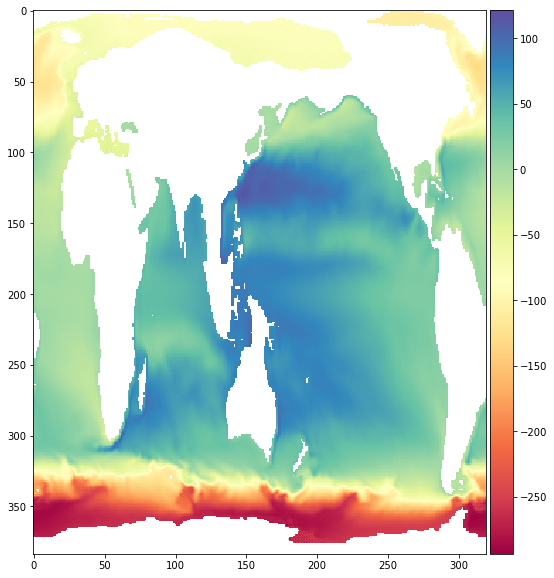

In [6]:
plt.figure(figsize=(10,10))
ax = plt.gca()
im = ax.imshow(np.flipud(sshdata), cmap=mpl.cm.Spectral)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

# Generating ocean-component based mask

In [7]:
from PySCRIP import _scrip
from PySCRIP.config import PySCRIPConfig
from PySCRIP.remap import __special__get_remap_data_to_ll1_grid

In [12]:
a = PySCRIPConfig()
map_ = a.getmap("21ka.tier1.CNDV.001", "conservative", "gx1", "ll1")

In [13]:
map_wts, src_add, dst_grid_size, dst_add, dst_mask = __special__get_remap_data_to_ll1_grid(map_.fname)

I just transform the test data here for check purposes

In [14]:
tmp_dst_array = np.zeros(dst_grid_size)
tmp_src_array = sshdata.flatten()

_scrip.remap(tmp_dst_array, map_wts, dst_add, src_add, tmp_src_array)

# reshape
plotdata = np.reshape(tmp_dst_array, (180, 360))

del tmp_dst_array, tmp_src_array

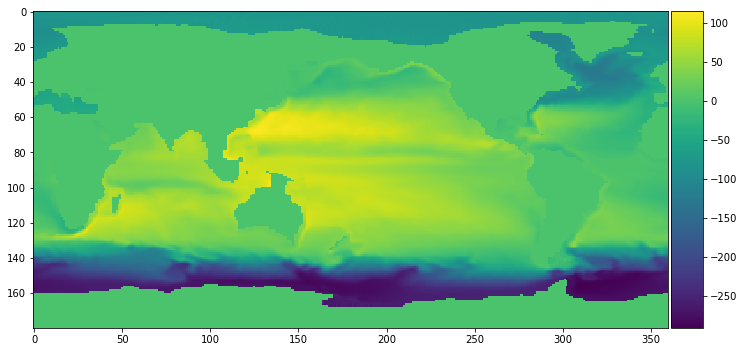

In [15]:
plt.figure(figsize=(12,8))
ax = plt.gca()
im = ax.imshow(np.flipud(plotdata))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

### Transforming the ocen-component based mask to 1x1 degree

In [17]:
tmp_dst_array = np.zeros(dst_grid_size)
tmp_src_array = (~sshdata.mask).flatten()

_scrip.remap(tmp_dst_array, map_wts, dst_add, src_add, tmp_src_array)

In [18]:
# reshape
dst_array = np.reshape(tmp_dst_array, (180, 360))
plotmask = np.logical_not(np.round(dst_array).astype('b'))

del dst_array, tmp_dst_array, tmp_src_array

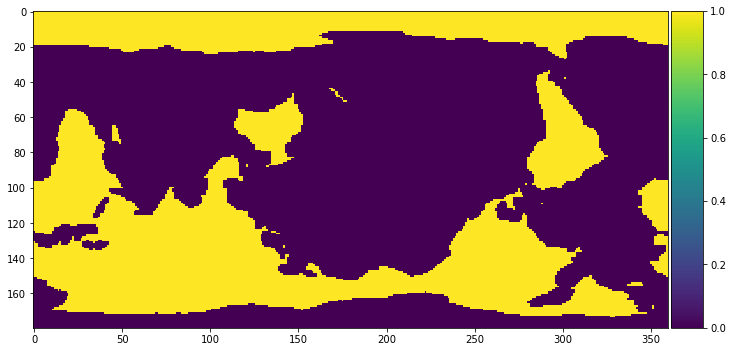

In [19]:
plt.figure(figsize=(12,8))
ax = plt.gca()
im = ax.imshow(plotmask)
# plt.colorbar()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

## Generating input topography based mask

In [24]:
# ncfile = Dataset("/Users/dchandan/Research/PMIP4/bc/Misc_stuff/i6gaocnx1_21k-0k+etopo_1deg_topo_v2.nc", "r")
# _topo = ncfile.variables["ftopo"][:,:]
# lats = ncfile.variables["lat"][:]
# lons = ncfile.variables["lon"][:]
# ncfile.close()
# externalmask = np.zeros_like(_topo)
# externalmask[_topo > 0.7] = 1.

# del _topo

ncfile = Dataset("/Users/dchandan/Research/PMIP4/bc/LGM6GC/datain/topo_1deg.nc")
_topo = np.zeros((180,360))
_topo[ncfile.variables["orog"][:,:] > 0] = 1
lats = ncfile.variables["lat"][:]
lons = ncfile.variables["lon"][:]
ncfile.close()
externalmask = np.copy(_topo)

del _topo

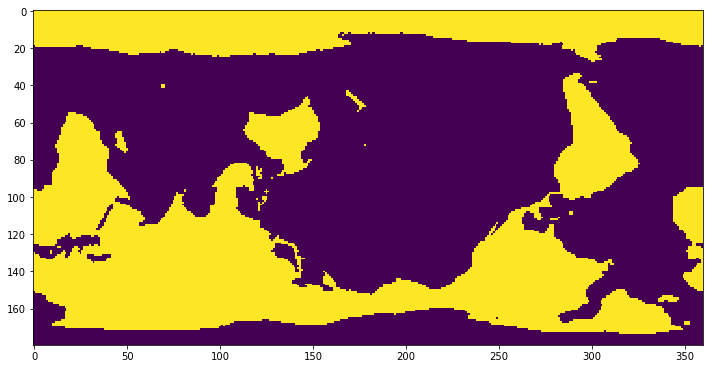

In [25]:
plt.figure(figsize=(12,8))
plt.imshow(externalmask)

Now, we construct the final mask at the union of the two masks. Additionally, I make the ocean grid cells as masked cells. 

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


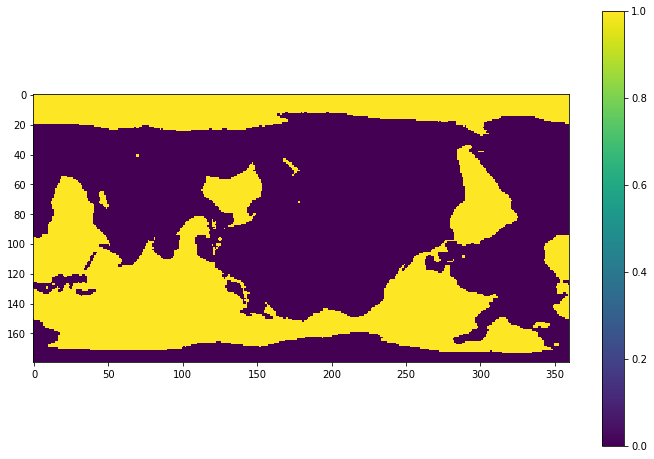

In [26]:
plt.figure(figsize=(12,8))
finalmask = np.logical_or(externalmask, plotmask).astype('f4')
print(finalmask)
# finalmask = np.ma.MaskedArray(finalmask, mask=[finalmask==0])
plt.imshow(finalmask); plt.colorbar()

In [27]:
plotdata_cmask = np.ma.MaskedArray(plotdata, mask=finalmask)
# plotdata_cmask = np.ma.MaskedArray(plotdata, mask=plotmask)

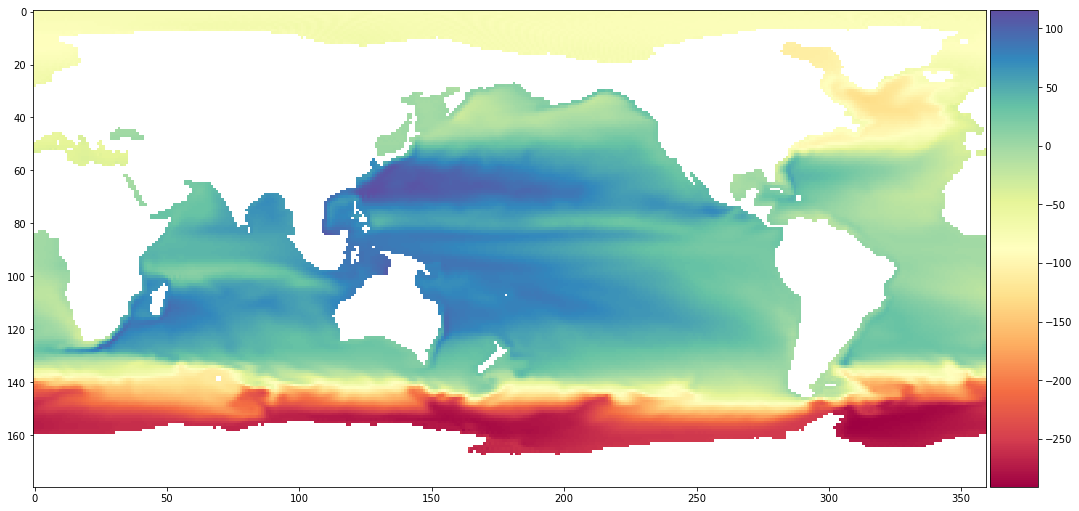

In [28]:
plt.figure(figsize=(18,9))
ax = plt.gca()
im = ax.imshow(np.flipud(plotdata_cmask), cmap=mpl.cm.Spectral)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()

In [31]:
ncfile = Dataset("/Users/dchandan/Research/CESM/mapping/cmask_LGM6GC.nc", "w")

ncfile.createDimension("lon", 360)
ncfile.createDimension("lat", 180)

var = ncfile.createVariable("lon", "f4", ("lon",))
var[:] = lons
var.units = "degrees_east"
var.long_name = "longitude"
var.standard_name = "longitude"

var = ncfile.createVariable("lat", "f4", ("lat",))
var[:] = lats
var.units = "degrees_north"
var.long_name = "latitude"
var.standard_name = "latitude"


# var = ncfile.createVariable("mask", "f4", ("lat","lon"), fill_value=default_fillvals['f4'])
var = ncfile.createVariable("mask", "i2", ("lat","lon"))
var[:,:] = finalmask
# var[:,:] = plotmask


ncfile.description = "Continent mask on 1x1 grid for the case of ICE6C layout."
ncfile.created = datetime.datetime.ctime(datetime.datetime.now())
ncfile.author = "Deepak Chandan"

ncfile.close()